About the Dataset:
There are 2 columns, first column contains the label, the second column contains the raw strings.

Importing the necessary dependencies:

In [16]:
import pandas as pd
import re
import nltk 
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tanji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Viewing the first few rows of the dataset:

In [17]:
email_data = pd.read_csv("smsSpam.txt",sep="\t",header=None, names=["label", "content"])
email_data['label']=email_data["label"].apply(lambda x: 1 if x=="spam" else 0) # change the label to 0 and 1
print(email_data.head())

   label                                            content
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...


Spam emails usually contain hashtags , links , emails and links. Before cleaning the data for vectorization, Extracting these features :

In [18]:
SPECIALSYMBOLS =set("@$%&*#^~+=")
def styling(content):
    #for letters only 
    letters = [c for c in content if c.isalpha()]
    upper_ratio = sum(1 for c in letters if c.isupper())/len(letters) if letters else 0
    #counts :
    exclamation_count = content.count("!")
    question_count = content.count("?")
    #special signs 
    special_sign = sum(c in SPECIALSYMBOLS for c in content)
    #URL count 
    url_count = len(re.findall(r"https?://[^\s]+", content, re.IGNORECASE))

    return pd.Series({
        "upper ratio": upper_ratio,
        "exclamation count ": exclamation_count ,
        "question count": question_count,
        "special count": special_sign,
        "url count": url_count
    })


Adding the  style features to the rows :

In [19]:
email_data[["upper ratio", "exclamation count", "question count", "special count", "url count"]] = email_data["content"].apply(styling)

Clean the dataset for vectorization :

In [20]:
# to find amount of null
email_data.isnull().sum()
print(email_data.dtypes)

label                  int64
content               object
upper ratio          float64
exclamation count    float64
question count       float64
special count        float64
url count            float64
dtype: object


Stemmer functions takes raw string and filters to keep only letters.Converts all to lowercase, stems the words. 
Then it is split to a linked list and filtered to removed stopwords. Finally , string is gotten from filtered linked list that is fit for vectorization

In [21]:

pstem = PorterStemmer()
def cleanse(content):
    new_content = re.sub(r"[^a-z]",' ',content)
    new_content = new_content.lower()
    new_content = new_content.split()
    new_content =[pstem.stem(word) for word in new_content if not word in stopwords.words('english')]
    new_content= ' '.join(new_content)
    return new_content


In [22]:
email_data["cleaned"]= email_data["content"].apply(cleanse)

Into the vectorization to convert text to numerical data :

In [23]:
# print(email_data.columns)
vectorizer = TfidfVectorizer(max_features = 3500, ngram_range=(1,2))
X_vec = vectorizer.fit_transform(email_data['cleaned']) #a sparse matrix

get the numeric data
and scaling :

In [24]:
x_num = email_data[["upper ratio", "exclamation count", "question count", "special count", "url count"]].values
x_all = sp.hstack([X_vec,x_num])
y = email_data['label']
print(y.shape, " ",x_all.shape)

(5572,)   (5572, 3505)


Splittting the Dataset to training and testing models

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(x_all,y,test_size=0.1, stratify=y, random_state=2)
model = LogisticRegression()
model.fit(X_train, Y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


Evaluation of Accuracy :

In [26]:
prediction_T = model.predict(X_train)
training_data_accuracy = accuracy_score(prediction_T, Y_train)
print("Training data accuracy : ",training_data_accuracy )

Training data accuracy :  0.9752692461108895


Accuracy score on test data :

In [27]:
prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(prediction, Y_test)
print("Test data Accuracy : ",test_data_accuracy )

Test data Accuracy :  0.9731182795698925


Prediction Interface :

In [28]:
x_new = X_test[3]
pred = model.predict(x_new)
print(pred)
if( pred == 0):
    print("Fake news")
else :
    print("Proper")


[0]
Fake news


Visualizing tendencies of capitalization and use of exclamation point in Spam messages

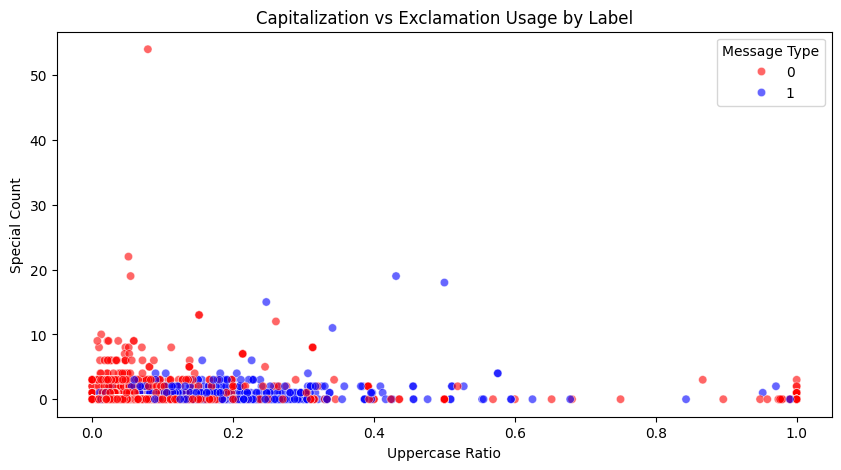

In [29]:
plt.figure(figsize=(10,5))
sns.scatterplot(
    data=email_data,
    x='upper ratio',
    y='special count',
    hue='label',
    palette={0: 'red', 1: 'blue'},
    alpha=0.6
)

plt.title('Capitalization vs Exclamation Usage by Label')
plt.xlabel('Uppercase Ratio')
plt.ylabel('Special Count')
plt.legend(title='Message Type')
plt.show()

As evident , the Spam messages have a higher capitalization count on average

In [30]:
print(email_data['url count'].sum())

20.0
